"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
#https://discourse.pymc.io/t/nuts-uses-all-cores/909/9

import os
os.environ["MKL_NUM_THREADS"]='1'
os.environ["OMP_NUM_THREADS"]='1'

In [2]:
base_dir = '/media/bigdata/projects/pytau'
import sys
sys.path.append(base_dir)
import pytau.changepoint_model as models

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Using directory: /media/bigdata/projects/pytau//pytau/how_to/examples/saved_models


In [3]:
import pickle
import scipy.stats as stats
import pymc3 as pm
import numpy as np
import pylab as plt
import arviz as az
import pandas as pd
import seaborn as sns

In [4]:
# np.__config__.show()

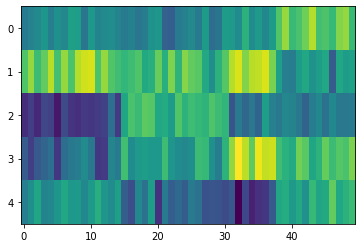

In [165]:
data_size = (5,50)
n_states = 4
data_array = models.gen_test_array(data_size, n_states, type = 'normal')
#data_array = np.random.randn(*data_size)
plt.imshow(data_array, aspect='auto');

In [166]:
# Create and fit model
n_fit = 80000
n_samples = 20000
max_states = 10

In [167]:
dpp_model = models.gaussian_changepoint_mean_dirichlet(data_array, max_states = max_states)

In [168]:
with dpp_model:
    spp = pm.sample_prior_predictive(samples = 5000)

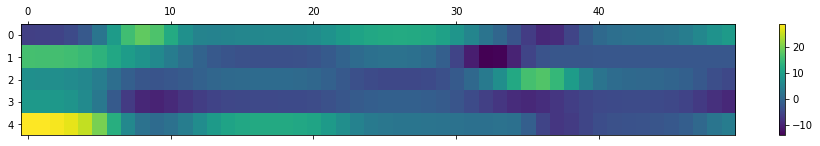

In [169]:
plt.matshow(spp['lambda_'][0], aspect='auto');plt.colorbar()

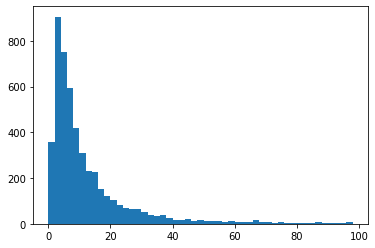

In [170]:
plt.hist(spp['alpha'],bins = np.arange(0,100,2));

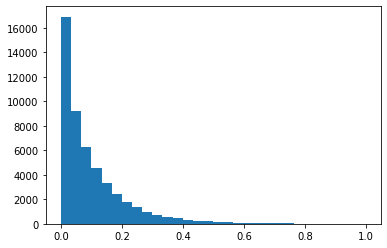

In [171]:
plt.hist(spp['w_latent'].flatten(), bins = 30);

In [172]:
sorted_w_latent = np.sort(spp['w_latent'],axis=-1)[:,::-1]
cumsum_w_latent = np.cumsum(sorted_w_latent, axis=-1)
mean_cumsum_w_latent = np.mean(cumsum_w_latent, axis=0)

(0.0, 1.0)

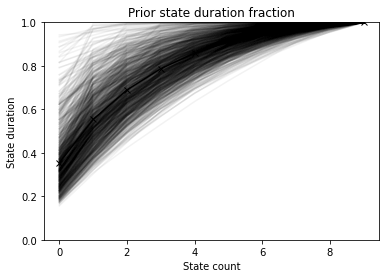

In [173]:
plt.plot(cumsum_w_latent[:1000].T, color = 'k', alpha = 0.05);
plt.plot(mean_cumsum_w_latent, color = 'k', marker = 'x')
plt.xlabel('State count')
plt.ylabel('State duration')
plt.title('Prior state duration fraction')
plt.ylim([0,1])

In [174]:
# pm.model_to_graphviz(dpp_model)

In [175]:
n_chains = 30
with dpp_model:
    dpp_trace = pm.sample(
                        tune = 500,
                        draws = 500, 
                          target_accept = 0.95,
                         chains = n_chains,
                         cores = 30,
                        return_inferencedata=False)
    
    #dpp_trace = pm.sample_smc(parallel = False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (30 chains in 30 jobs)
NUTS: [beta, alpha, b_gamma, a_gamma, sigma, lambda]


Sampling 30 chains for 500 tune and 500 draw iterations (15_000 + 15_000 draws total) took 203 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [176]:
w_latent_vals = dpp_trace['w_latent']

In [177]:
sorted_w_latent = np.sort(w_latent_vals,axis=-1)[:,::-1]
cumsum_w_latent = np.cumsum(sorted_w_latent, axis=-1)
mean_cumsum_w_latent = np.mean(cumsum_w_latent, axis=0)

(0.0, 1.0)

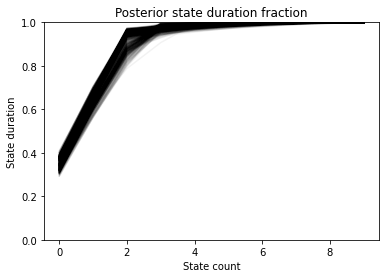

In [178]:
wanted_count = 1000
inds = np.random.choice(np.arange(len(cumsum_w_latent)), wanted_count)
plt.plot(cumsum_w_latent[inds].T, color = 'k', alpha = 0.05);
plt.xlabel('State count')
plt.ylabel('State duration')
plt.title('Posterior state duration fraction')
plt.ylim([0,1])
#plt.plot(mean_cumsum_w_latent, color = 'k', marker = 'x')

In [179]:
# with dpp_model:
#     az_trace = az.from_pymc3(dpp_trace)
    
# ax = az.plot_trace(az_trace, compact=True, kind="rank_vlines")

In [180]:
# with dpp_model:
#     pm.traceplot(dpp_trace, var_names = ['a_gamma','b_gamma','alpha']);

In [181]:
# with dpp_model:
#     pm.pairplot(dpp_trace, var_names = ['a_gamma','b_gamma','alpha'], divergences = True);

In [182]:
dpp_trace['w_latent'].shape

(15000, 10)

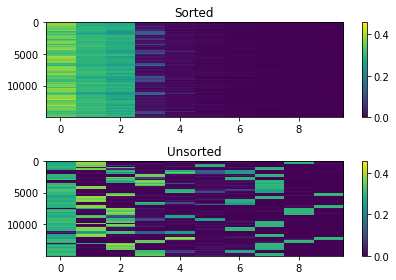

In [183]:
#sorted_lens = np.sort(dpp_trace['w_latent'],axis=-1)[:,::-1]
#w_latent_samples = dpp_trace.posterior.data_vars['w_latent'].values
w_latent_samples = dpp_trace['w_latent']
#cat_w_latent_samples = np.concatenate(w_latent_samples)
cat_w_latent_samples = w_latent_samples
sorted_lens = np.sort(cat_w_latent_samples,axis=-1)[:,::-1]
mean_lens = sorted_lens.mean(axis=0)
std_lens = sorted_lens.std(axis=0)

fig,ax = plt.subplots(2,1)
im1 = ax[0].imshow(sorted_lens, interpolation='nearest', aspect= 'auto')
im2 = ax[1].imshow(cat_w_latent_samples, interpolation='nearest', aspect= 'auto')
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_title('Sorted')
ax[1].set_title('Unsorted')
plt.tight_layout()

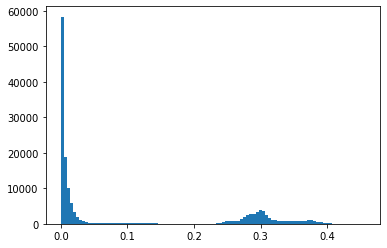

In [184]:
plt.hist(sorted_lens.flatten(), bins = 100);
#plt.yscale('log')

In [185]:
dpp_ppc = pm.sample_posterior_predictive(dpp_trace, 
                                         model = dpp_model)['obs']
dpp_ppc.shape

(15000, 5, 50)

In [186]:
mean_ppc = np.mean(dpp_ppc, axis=0)

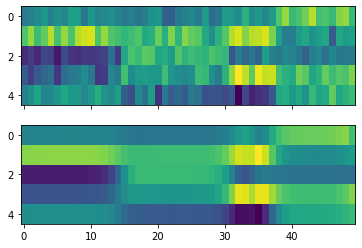

In [187]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
ax[0].imshow(data_array, aspect='auto', interpolation='nearest')
ax[1].imshow(mean_ppc, aspect='auto', interpolation='nearest')

In [188]:
sorted_w_latent = np.stack(np.array_split(np.sort(w_latent_samples,axis=-1)[...,::-1],n_chains,axis=0))
mean_sorted = np.mean(sorted_w_latent, axis = 1)

# all_state_edges = np.concatenate([[0],true_tau,[length]])
# state_durations = np.abs(np.diff(all_state_edges))
# sorted_state_durations = np.sort(state_durations / length)[::-1]
# shortest_state = sorted_state_durations[-1]

In [189]:
sorted_w_latent.shape

(30, 500, 10)

/home/abuzarmahmood/anaconda3/envs/pytau_env/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/abuzarmahmood/anaconda3/envs/pytau_env/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/abuzarmahmood/anaconda3/envs/pytau_env/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 56.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/abuzarmahmood/anaconda3/envs/pytau_env/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 36.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

Text(36.125, 0.5, 'Count')

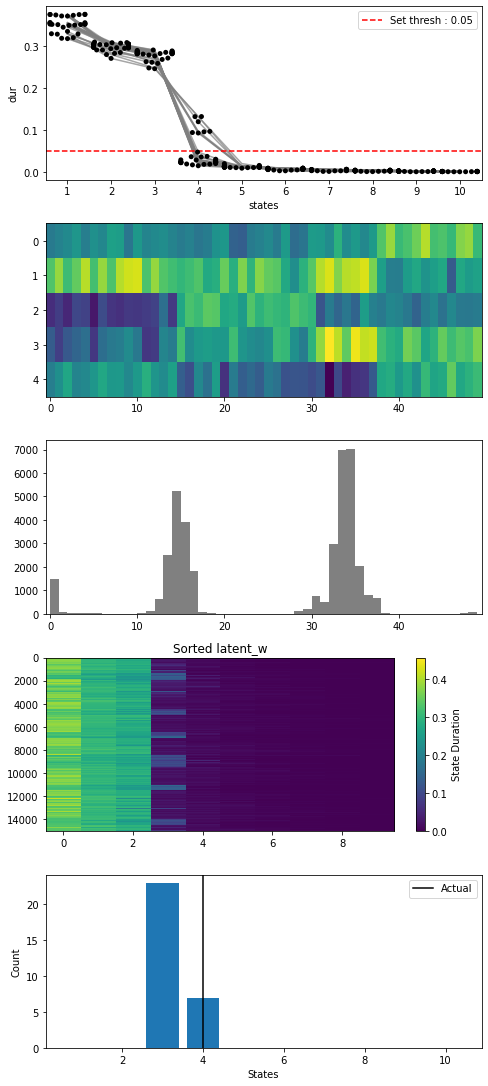

In [190]:
inds = np.array(list(np.ndindex(mean_sorted.shape)))
state_frame = pd.DataFrame(
                        dict(
                            chains = inds[:,0],
                            states = inds[:,1]+1,
                            dur = mean_sorted.flatten()
                        )
                    )

fig,ax = plt.subplots(5,1, figsize = (7,15))

sns.swarmplot(
    data = state_frame,
    x = 'states',
    y = 'dur',
    color = 'k',
    ax = ax[0]
);
ax[0].plot(mean_sorted.T, alpha = 0.7, color = 'grey')
set_thresh = 0.05

# ax[0].axvline(states-1, zorder = -1, color = 'black', label = 'Actual')
# ax[0].legend()
ax[0].axhline(set_thresh, color = 'red', linestyle = '--',
             label = f'Set thresh : {set_thresh}')
# ax[0].text(0, shortest_state, 'Shortest state')
# ax[0].axhline(0.01, color = 'red', linestyle = '--')
# ax[0].text(0, 0.01, '0.01')
# # ax[0].axhline(0.05, color = 'red', linestyle = '--')
# # ax[0].text(0, 0.05, '0.05')
ax[0].legend()

#corrected_transitions = np.cumsum(sorted_w_latent,axis=-1)
#tau_samples = np.concatenate(dpp_trace.posterior.data_vars['tau'].values)
tau_samples = dpp_trace['tau']
ax[1].imshow(data_array,aspect='auto', interpolation = 'nearest')
for x in tau_samples.T:
    ax[2].hist(x, bins = np.arange(data_size[1]), color = 'grey')
ax[2].sharex(ax[1])
    
im1 = ax[3].imshow(sorted_lens, interpolation='nearest', aspect= 'auto')
ax[3].set_title('Sorted latent_w')
fig.colorbar(im1, ax=ax[3], label = 'State Duration')
plt.tight_layout()


max_state_per_chain = state_frame.loc[state_frame.dur > set_thresh].groupby('chains').max()
max_state_counts = max_state_per_chain.groupby('states').count()
state_vec = np.arange(1,max_states+1)
counts = [max_state_counts.loc[x].values[0] if x in max_state_counts.index else 0 for x in state_vec ]
ax[4].axvline(n_states, zorder = 2, color = 'black', label = 'Actual')
ax[4].legend()
ax[4].bar(state_vec, counts)
ax[4].set_xlabel("States")
ax[4].set_ylabel('Count')

#fig.savefig(f'/home/abuzarmahmood/Pictures/dirichlet_state_comparison/{states}_state.png')

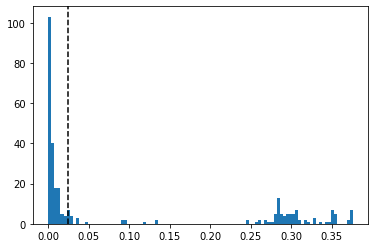

In [191]:
plt.hist(mean_sorted.flatten(), bins = 100);
plt.axvline(0.025, color = 'k', linestyle = '--')

## Examples of changepoints for different numbers of states

In [192]:
# States per threshold
threshold_vec = np.linspace(0,0.05,20)
state_counts = np.stack([np.sum(sorted_lens>this_thresh,axis=-1) \
               for this_thresh in threshold_vec])
state_counts.shape

(20, 15000)

In [193]:
from collections import Counter

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
def no_y_axis(ax):
    ax.spines['left'].set_visible(False)
    #ax.set_yticks([])

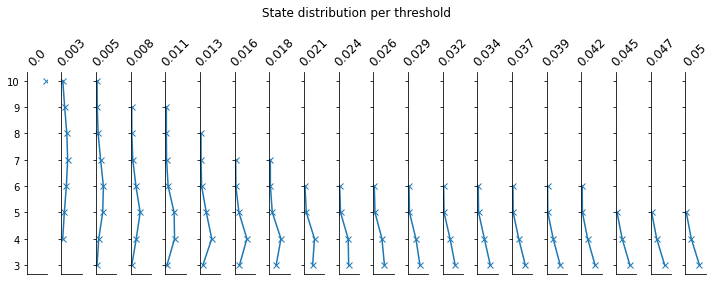

In [194]:
fig,ax = plt.subplots(1, len(state_counts), 
                      sharex=True, sharey=True,
                     figsize = (10,4))
for i, (this_dat, this_ax) in enumerate(zip(state_counts, ax)):
    #vals, edges = np.histogram(this_dat, bins = np.arange(max_states))
    count_dict = Counter(this_dat)
    states, vals = count_dict.keys(), count_dict.values()
    states = np.array(list(states))
    vals = np.array(list(vals))
    if len(states) > 1:
        sort_order = np.argsort(states)
        states = states[sort_order]
        vals = vals[sort_order]
    this_ax.plot(vals, states, '-x')
    simpleaxis(this_ax)
    this_ax.set_xticks([])
    #if i>1:
    #    no_y_axis(this_ax)
    this_ax.set_title(np.round(threshold_vec[i],3), rotation = 45)

fig.suptitle('State distribution per threshold');
plt.tight_layout()

In [195]:
wanted_thresh = 0.05

In [196]:
tau_samples.shape

(15000, 9)

In [197]:
sorted_lens.shape

(15000, 10)

In [198]:
fin_state_counts = np.sum(sorted_lens > wanted_thresh, axis=-1)
unique_states = np.unique(fin_state_counts)

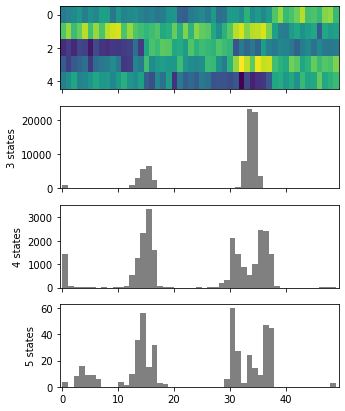

In [204]:
fig, ax = plt.subplots(len(unique_states)+1, 1, 
                       sharex=True,
                      figsize = (5,7))
for i in range(len(ax)):
    this_ax = ax[i]
    if i:
        this_states = unique_states[i-1]
        this_inds = fin_state_counts == this_states
        this_dat = tau_samples[this_inds]
        this_ax.hist(this_dat.flatten(), bins = np.arange(data_size[1]), color = 'grey')
        this_ax.set_ylabel(f'{this_states} states')
    else:
        this_ax.imshow(data_array,aspect='auto', interpolation = 'nearest')